<a href="https://colab.research.google.com/github/codelalala/ML/blob/main/DETR_Panoptic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from PIL import Image,ImageDraw,ImageFont
import requests
import io
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False)

In [4]:
!pip -q install git+https://github.com/cocodataset/panopticapi.git

In [5]:
import panopticapi
from panopticapi.utils import id2rgb,rgb2id

In [6]:
#COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

transform=T.Compose([
                     T.Resize(800),
                     T.ToTensor(),
                     T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [7]:
#load model
model,postprocessor=torch.hub.load(
    'facebookresearch/detr','detr_resnet101_panoptic',pretrained=True,
    return_postprocessor=True,num_classes=250)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


In [8]:
url="https://static01.nyt.com/images/2020/12/18/nyregion/00-nyc-open-streets-still02/00-nyc-open-streets-still02-superJumbo.jpg"
im=Image.open(requests.get(url,stream=True).raw)

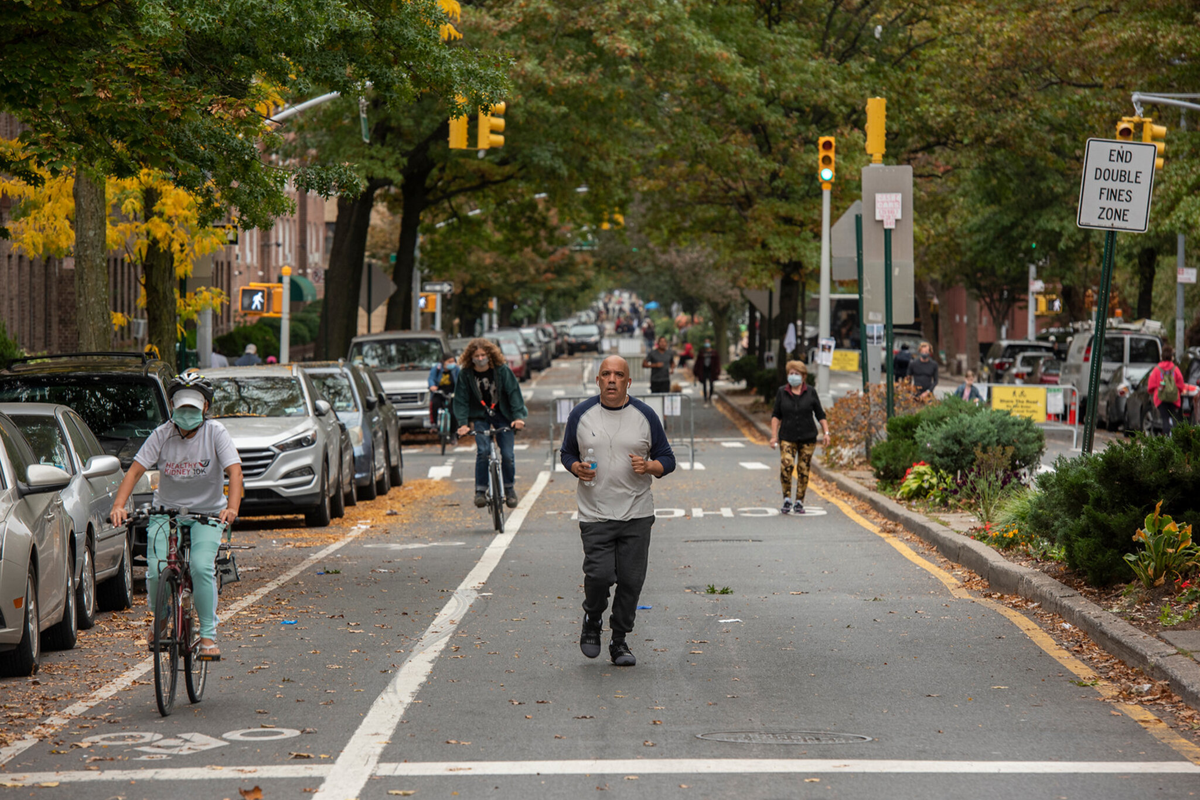

In [9]:
im2=im.resize((1200,800))
im2

In [10]:
#make prediction
img=transform(im).unsqueeze(0)
out=model(img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


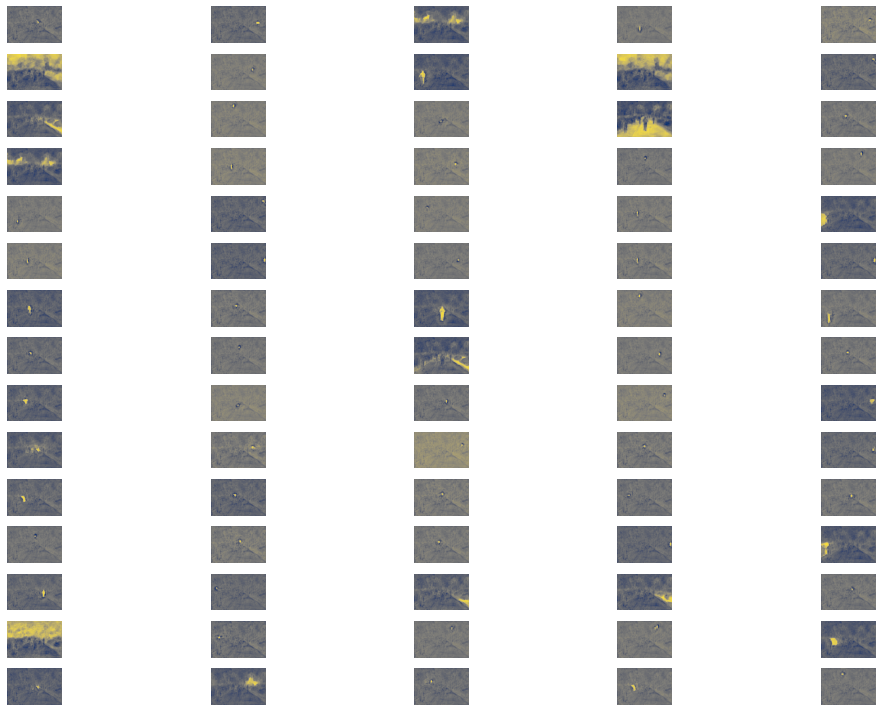

In [11]:
scores=out["pred_logits"].softmax(-1)[...,:-1].max(-1)[0]
keep=scores>0.25
ncols=5
fig,axs=plt.subplots(ncols=ncols,nrows=math.ceil(keep.sum().item()/ncols),
                     figsize=(18,10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(out["pred_masks"][keep]):
    ax=axs[i//ncols,i%ncols]
    ax.imshow(mask,cmap="cividis")
    ax.axis('off')
    fig.tight_layout()

In [12]:
result=postprocessor(out,torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


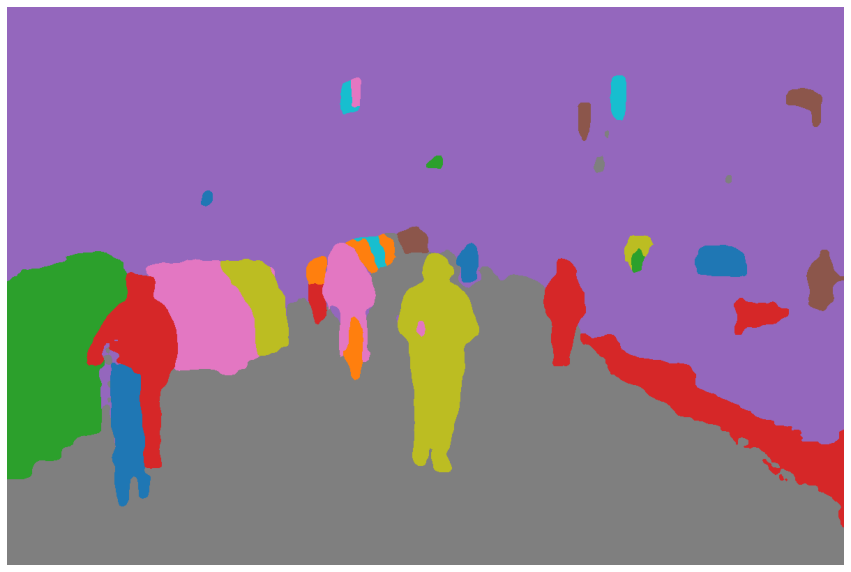

In [13]:
import itertools
import seaborn as sns
palette=itertools.cycle(sns.color_palette())

panoptic_seg=Image.open(io.BytesIO(result['png_string']))
panoptic_seg=numpy.array(panoptic_seg,dtype=numpy.uint8).copy()
panoptic_seg_id=rgb2id(panoptic_seg)

panoptic_seg[:,:,:]=0
for id in range(panoptic_seg_id.max()+1):
    panoptic_seg[panoptic_seg_id==id]=numpy.asarray(next(palette))*255
plt.figure(figsize=(15,15))
plt.imshow(panoptic_seg)
plt.axis('off')
plt.show()

(-0.5, 1199.5, 799.5, -0.5)

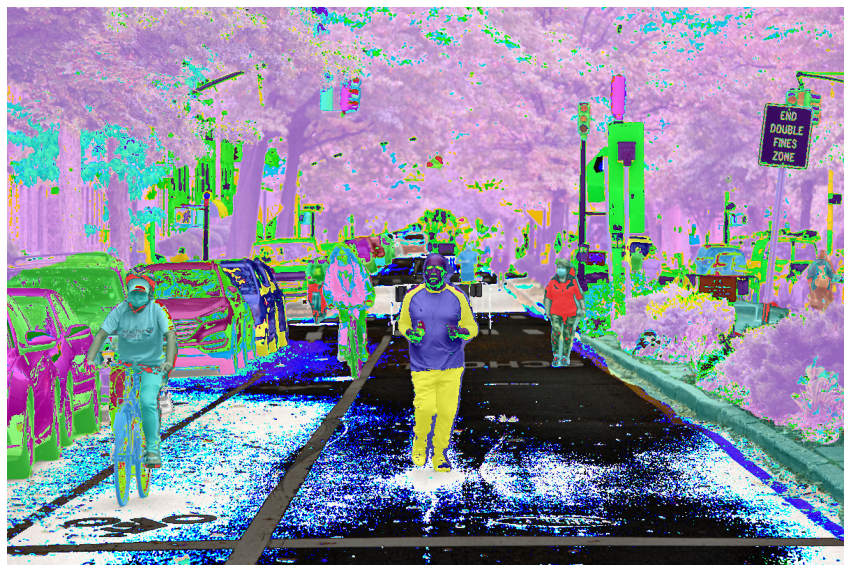

In [17]:
plt.figure(figsize=(15,15))
plt.imshow(panoptic_seg+im2)
plt.axis('off')